In [109]:
# # for colab
# from google.colab import drive
# drive.mount('/content/drive')
# % cd drive/MyDrive/Plankton-Patrol/notebooks/plankton_patrol_models

# Introduction

This notebook is for practicing XGBoost and initial analyzation of Water Quality dataset from the [Chesapeake Bay Project DataHub](https://datahub.chesapeakebay.net/WaterQuality). 

In [34]:
import shap
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

In [35]:
water = pd.read_csv('../../data/plank_ChesapeakeWaterQuality_clean.csv')

/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_42444/4047237986.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  water = pd.read_csv('../../data/plank_ChesapeakeWaterQuality_clean.csv')


# Basic set up

In [36]:
water.shape

(39490, 66)

In [37]:
water['EventId'].nunique()

20140

Let's remove columns missing more than 90% of the values.

In [38]:
threshold = 0.9

missing_percentage = water.isnull().mean()

columns_to_keep = missing_percentage[missing_percentage <= threshold].index

# Create a new DataFrame with only the columns to keep
water_clean = water[columns_to_keep]

print('Remaining columns:', water_clean.columns)


Remaining columns: Index(['CBSeg2003', 'EventId', 'Cruise', 'Program', 'Project', 'Agency',
       'Source', 'Station', 'SampleDate', 'SampleTime', 'TotalDepth',
       'UpperPycnocline', 'LowerPycnocline', 'Depth', 'Layer', 'SampleType',
       'SampleReplicateType', 'Qualifier', 'Method', 'Lab', 'Problem',
       'Details', 'Latitude', 'Longitude', 'TierLevel', 'AirTemp', 'WindSpeed',
       'WindDirection', 'TideStage', 'WaveHeight', 'CloudCover', 'CHLA', 'DIN',
       'DO', 'DON', 'DOP', 'FSS', 'KD', 'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC',
       'PH', 'PHEO', 'PN', 'PO4F', 'PP', 'SALINITY', 'SECCHI', 'SIF',
       'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP', 'TSS', 'VSS',
       'WTEMP'],
      dtype='object')


In [39]:
water_clean.shape

(39490, 61)

## XGBoost

Since this dataset did not include any chlrophyl data, we will pick some other parameters to model. How about `PCT_PI_BIO` - Percent Pollution Indicative Species.

### Preprocess

Converting `SampleDateTime` to an integer. First converting back to datetime.

In [40]:
water_clean = water_clean.copy()

water_clean['SampleDateTime'] = pd.to_datetime(water_clean['SampleDate'] + ' ' + water_clean['SampleTime'], format='%m/%d/%Y %H:%M:%S')

water_clean['IntDateTime'] = water_clean['SampleDateTime'].astype('int64')//10**9

water_clean['floatDateTime'] = water_clean['IntDateTime'].astype('float64')


water_clean = water_clean.drop(columns=['SampleDateTime','IntDateTime'])

Modifying Pushkar's function for converting datatypes, we make sure every column is either a float or category.

In [41]:
numerical_features = water_clean.select_dtypes(include='float').columns
categorical_features = list(set(water_clean.columns) - set(numerical_features))

In [42]:
def convert_dtypes(df):
    for col in df.columns:
        df[col] = df[col].replace("nan", np.nan)
        # print(df[col][564463])
        print(f"converting column {col}",end="\t")
        print(df[col].dtype)

        if col not in (numerical_features):
            df[col] = pd.Categorical(df[col])
            print("Categorical")
        elif col in numerical_features:
            # Try converting to numeric (float)
            df[col] = pd.to_numeric(df[col], errors="coerce")

            # Handle missing values
            df[col].fillna(df[col].median(), inplace=True)
            print("Numeric")
        else:
            print(f"{col}: string")
            df[col] = df[col].astype(str)
            print("string")
        print(df[col].dtype)
    return df

In [43]:
water_clean = convert_dtypes(water_clean)

converting column CBSeg2003	object
Categorical
category
converting column EventId	float64


Numeric
float64
converting column Cruise	object
Categorical
category
converting column Program	object
Categorical
category
converting column Project	object
Categorical
category
converting column Agency	object
Categorical
category
converting column Source	object
Categorical
category
converting column Station	object
Categorical
category
converting column SampleDate	object
Categorical
category
converting column SampleTime	object
Categorical
category
converting column TotalDepth	float64
Numeric
float64
converting column UpperPycnocline	float64
Numeric
float64
converting column LowerPycnocline	float64
Numeric
float64
converting column Depth	float64
Numeric
float64
converting column Layer	object
Categorical
category
converting column SampleType	object
Categorical
category
converting column SampleReplicateType	object
Categorical
category
converting column Qualifier	object
Categorical
category
converting column Method	object
Categorical
category
converting column Lab	object
Categorical
categor

/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_42444/514992669.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_42444/514992669.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

Categorical
category
converting column AirTemp	float64
Numeric
float64
converting column WindSpeed	object
Categorical
category
converting column WindDirection	object
Categorical
category
converting column TideStage	object
Categorical
category
converting column WaveHeight	object
Categorical
category
converting column CloudCover	object
Categorical
category
converting column CHLA	float64
Numeric
float64
converting column DIN	float64
Numeric
float64
converting column DO	float64
Numeric
float64
converting column DON	float64
Numeric
float64
converting column DOP	float64
Numeric
float64
converting column FSS	float64
Numeric
float64
converting column KD	float64
Numeric
float64
converting column NH4F	float64
Numeric
float64
converting column NO23F	float64
Numeric
float64
converting column NO2F	float64
Numeric
float64
converting column NO3F	float64
Numeric
float64
converting column PC	float64
Numeric
float64
converting column PH	float64
Numeric
float64
converting column PHEO	float64
Numeric
floa

/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_42444/514992669.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_42444/514992669.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

Let's check

In [44]:
water_clean.dtypes

CBSeg2003        category
EventId           float64
Cruise           category
Program          category
Project          category
                   ...   
TP                float64
TSS               float64
VSS               float64
WTEMP             float64
floatDateTime     float64
Length: 62, dtype: object

### Define and train regression


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def split_data(water_clean):
  # Split features and target
  X = water_clean.drop('CHLA', axis=1)
  y = water_clean['CHLA']

  for col in X.select_dtypes(include=['category']).columns:
    X[col] = X[col].cat.codes

  print(X.shape, y.shape)
   
  # Split into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = split_data(water_clean)

(39490, 61) (39490,)


In [46]:
params = dict()
params["tree_method"] = "hist"

In [47]:
model = xgb.XGBRegressor(enable_categorical=True)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [48]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE: %f" % (mse))

MSE: 21.734493


## Estimate the Shapley values

Copied from Pushkar

In [49]:


explainer = shap.Explainer(model=model, masker=X_train)
explainer.__class__

# explainer = shap.TreeExplainer(model, data=cp.asarray(X_train_cp))
# shap_values = explainer.shap_values(cp.asarray(X_test_cp))

# Convert Shapley values back to NumPy arrays for compatibility
# shap_values = cp.asnumpy(shap_values)

shap.explainers._tree.TreeExplainer

In [50]:
shap_values = explainer(X_test)

 98%|===================| 7750/7898 [00:21<00:00]        

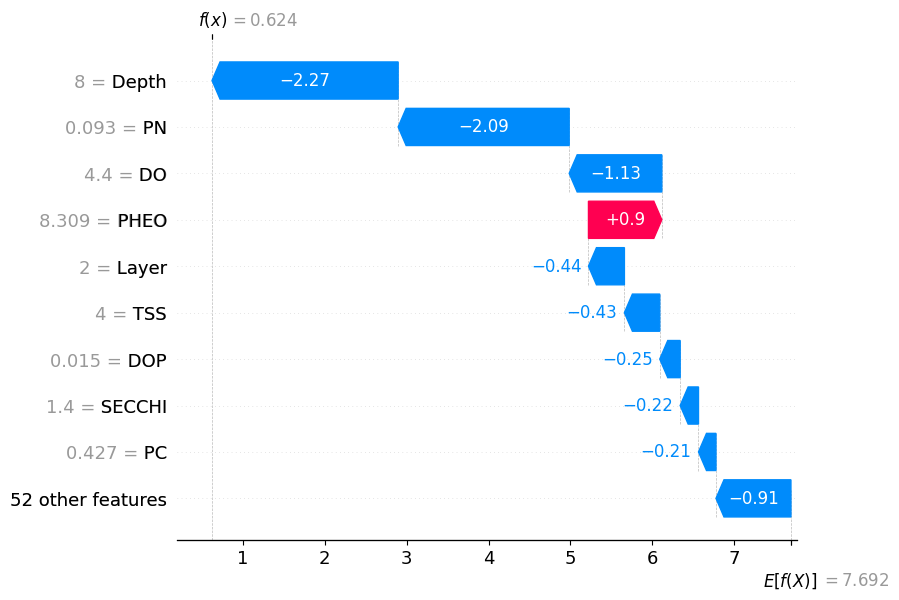

In [51]:
shap.plots.waterfall(shap_values[0])

In [52]:
shap.initjs()

shap.plots.force(shap_values[0])

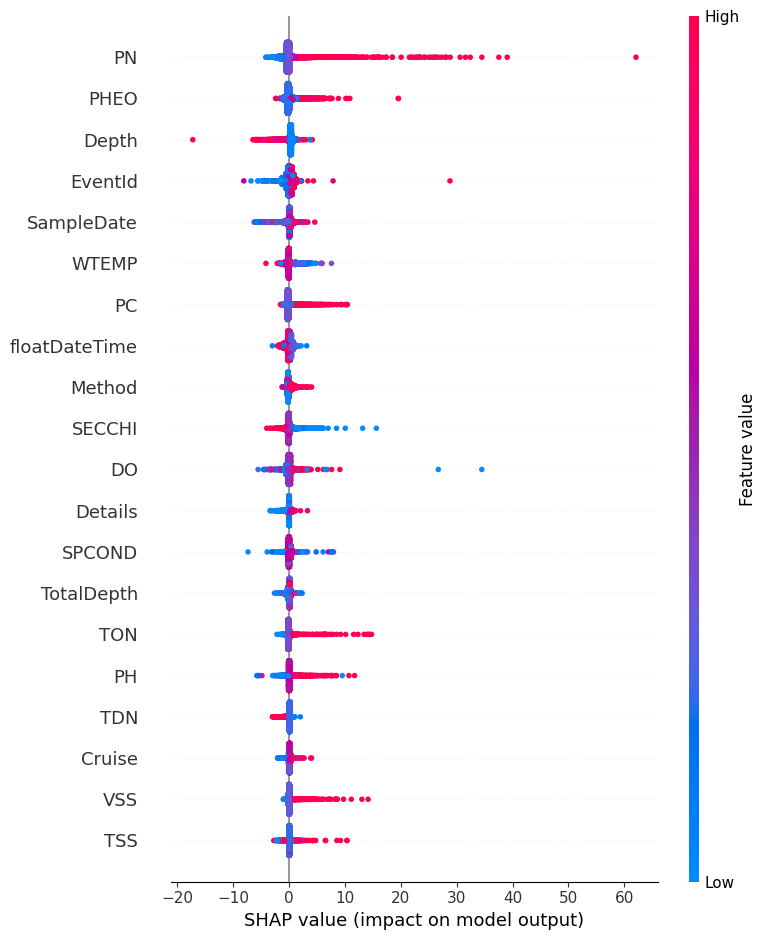

In [53]:
shap.summary_plot(shap_values,X_test)

# A bit more cleaning

Let's drop som columns related to who collected the data: `Program`, `Project`, `Agency`, `Source`, and `TierList`.
And `TotalDepth` is the station, not the sample. `EventId` was useful for cleaning/combining data. `Method` and `Lab` should not afftect the data. `VSS` seems to be a measurement of sustainability.

In [54]:
water_clean = water_clean.drop(columns=['Program','Project','Agency','Source','TotalDepth','TierLevel','EventId','Method','VSS','Lab'])

In [55]:
water_clean = convert_dtypes(water_clean)

converting column CBSeg2003	category
Categorical
category
converting column Cruise	category
Categorical
category
converting column Station	category
Categorical
category
converting column SampleDate	category
Categorical
category
converting column SampleTime	category
Categorical
category
converting column UpperPycnocline	float64
Numeric
float64
converting column LowerPycnocline	float64
Numeric
float64
converting column Depth	float64
Numeric
float64
converting column Layer	category
Categorical
category
converting column SampleType	category
Categorical
category
converting column SampleReplicateType	category
Categorical
category
converting column Qualifier	category
Categorical
category
converting column Problem	category
Categorical
category
converting column Details	category
Categorical
category
converting column Latitude	float64
Numeric
float64
converting column Longitude	float64
Numeric
float64
converting column AirTemp	float64
Numeric
float64
converting column WindSpeed	category
Categori

/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_42444/514992669.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_42444/514992669.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

### Define and train regression


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def split_data(water_clean):
  # Split features and target
  X = water_clean.drop('CHLA', axis=1)
  y = water_clean['CHLA']

  for col in X.select_dtypes(include=['category']).columns:
    X[col] = X[col].cat.codes

  print(X.shape, y.shape)
   
  # Split into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = split_data(water_clean)

(39490, 51) (39490,)


In [57]:
params = dict()
params["tree_method"] = "hist"

In [58]:
model = xgb.XGBRegressor(enable_categorical=True)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [59]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE: %f" % (mse))

MSE: 21.654235


## Estimate the Shapley values

Copied from Pushkar

In [60]:


explainer = shap.Explainer(model=model, masker=X_train)
explainer.__class__

# explainer = shap.TreeExplainer(model, data=cp.asarray(X_train_cp))
# shap_values = explainer.shap_values(cp.asarray(X_test_cp))

# Convert Shapley values back to NumPy arrays for compatibility
# shap_values = cp.asnumpy(shap_values)

shap.explainers._tree.TreeExplainer

In [61]:
shap_values = explainer(X_test)

 99%|===================| 7784/7898 [00:20<00:00]        

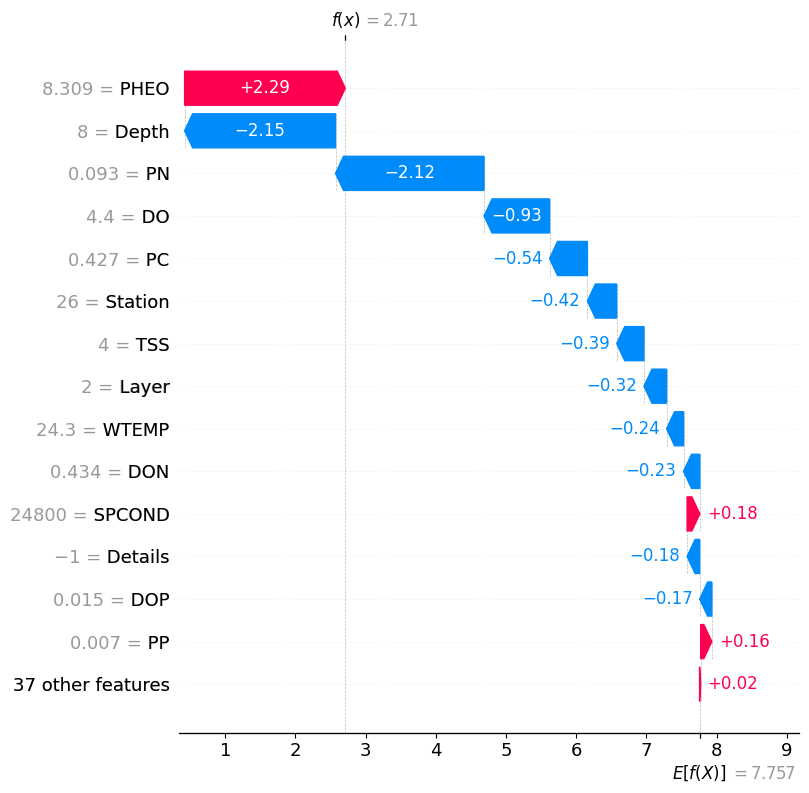

In [62]:
shap.plots.waterfall(shap_values[0],max_display=15)

In [63]:
shap.plots.force(shap_values[0])

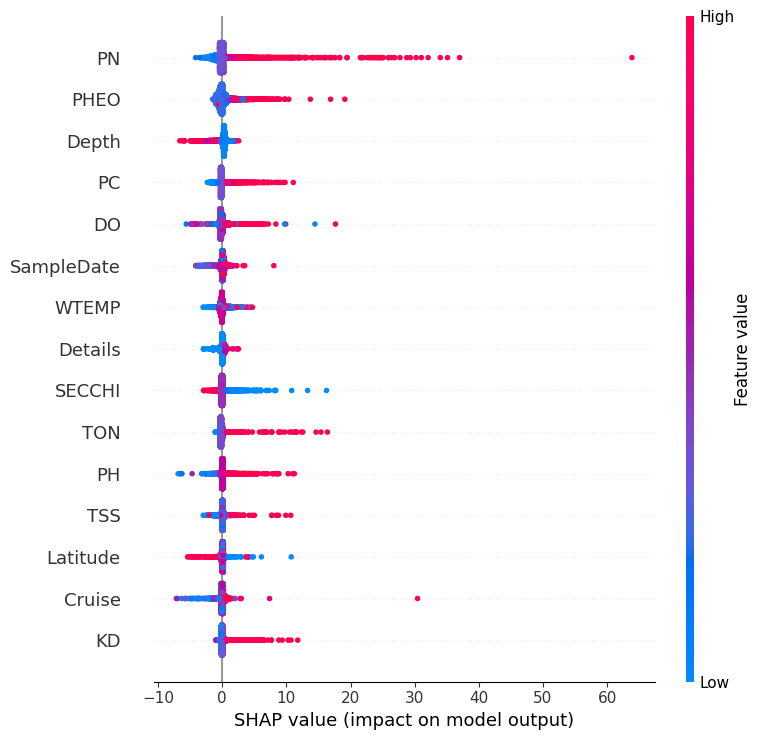

In [64]:
shap.summary_plot(shap_values,X_test,max_display=15)

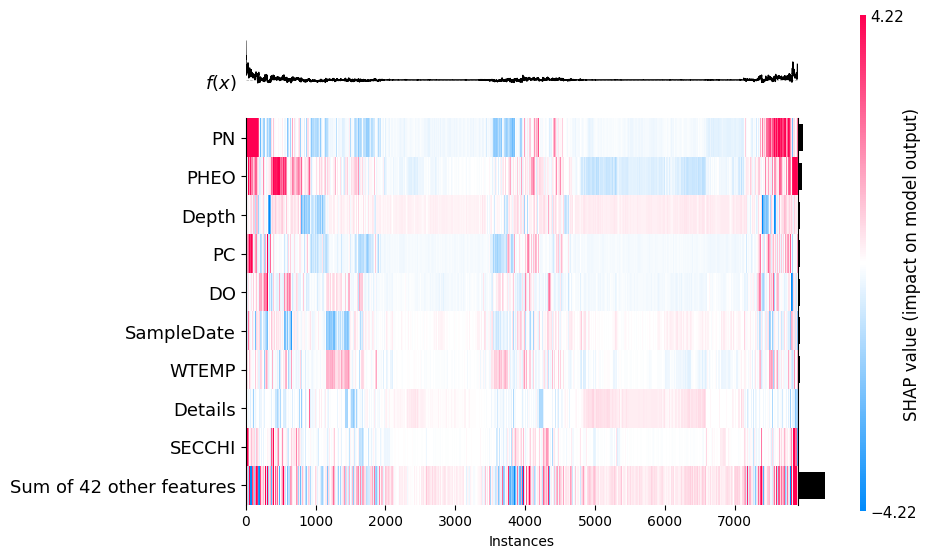

<Axes: xlabel='Instances'>

In [66]:
shap.plots.heatmap(shap_values)